### Data preparation
Initial data overwiev and basic models testing.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/train.csv", delimiter="|")

In [3]:
df.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,3.401809,932.153273,50.864492,5.469931,4.904204,2.525279,0.058138,0.201746,0.745404,0.055349
std,1.709404,530.144640,28.940202,3.451169,3.139697,1.695472,0.278512,1.242135,1.327241,0.228720
min,1.000000,2.000000,0.010000,0.000000,0.000000,0.000000,0.000548,0.000007,0.000000,0.000000
25%,2.000000,474.500000,25.965000,2.000000,2.000000,1.000000,0.008384,0.027787,0.160000,0.000000
50%,3.000000,932.000000,51.210000,5.000000,5.000000,3.000000,0.016317,0.054498,0.350000,0.000000
75%,5.000000,1397.000000,77.285000,8.000000,8.000000,4.000000,0.032594,0.107313,0.666667,0.000000
max,6.000000,1831.000000,99.960000,11.000000,10.000000,5.000000,6.666667,37.870000,11.000000,1.000000


In [4]:
df.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


### Class distribution.

In [5]:
positive = df[df['fraud']==1].count()[0]
negative = df[df['fraud']==0].count()[0]
print("Frauds: {}, non-frauds: {}, all: {}".format(positive, negative, positive+negative))

Frauds: 104, non-frauds: 1775, all: 1879


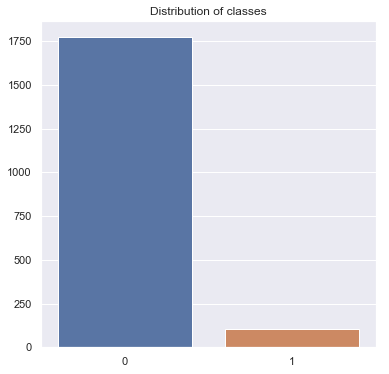

In [6]:
counts = [negative, positive]
plt.figure(figsize=(6,6))
plt.title("Distribution of classes")
sns.barplot(x=[0,1], y=counts)

The distribution of observations is highly imbalanced. This may lead to a situation when the model will learn to classify all examples as negative which will result in high accuracy with zero acctual value.

Before taking a look at the classifiaction let's brefly investigate the features.

### Features distributions

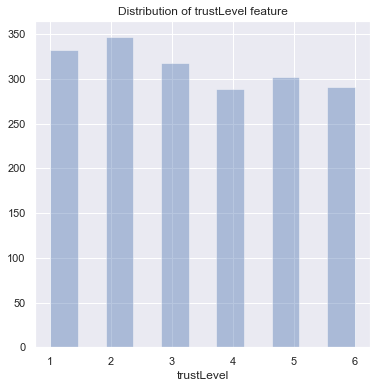

In [7]:
plt.figure(figsize=(6,6))
plt.title("Distribution of trustLevel feature")
sns.distplot(df.trustLevel, kde=False)

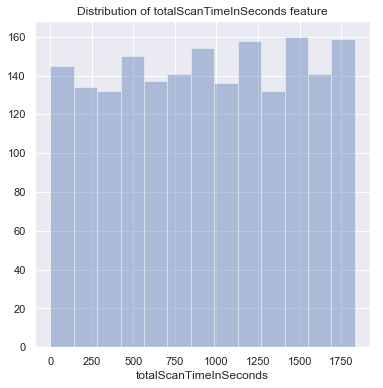

In [8]:
plt.figure(figsize=(6,6))
plt.title("Distribution of totalScanTimeInSeconds feature")
sns.distplot(df.totalScanTimeInSeconds, kde=False)

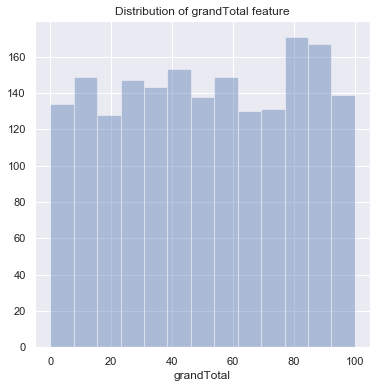

In [9]:
plt.figure(figsize=(6,6))
plt.title("Distribution of grandTotal feature")
sns.distplot(df.grandTotal, kde=False)

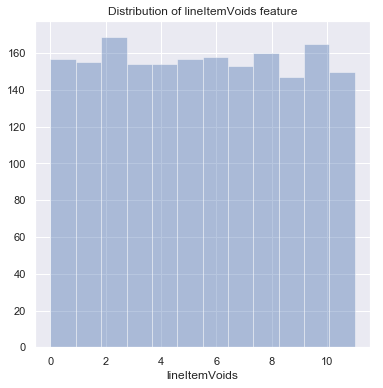

In [10]:
plt.figure(figsize=(6,6))
plt.title("Distribution of lineItemVoids feature")
sns.distplot(df.lineItemVoids, kde=False)

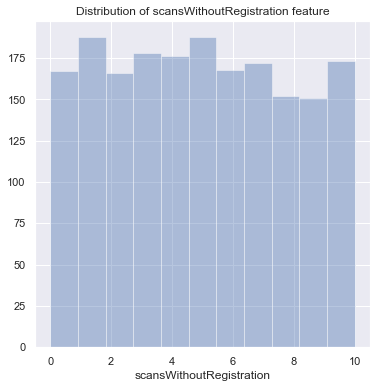

In [11]:
plt.figure(figsize=(6,6))
plt.title("Distribution of scansWithoutRegistration feature")
sns.distplot(df.scansWithoutRegistration, kde=False)

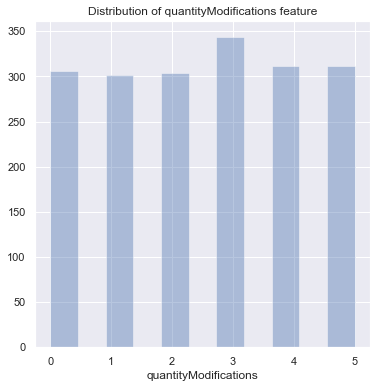

In [12]:
plt.figure(figsize=(6,6))
plt.title("Distribution of quantityModifications feature")
sns.distplot(df.quantityModifications, kde=False)

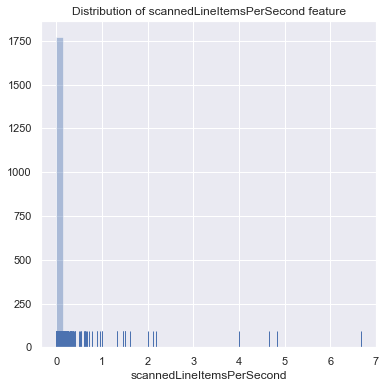

In [13]:
plt.figure(figsize=(6,6))
plt.title("Distribution of scannedLineItemsPerSecond feature")
sns.distplot(df.scannedLineItemsPerSecond, kde=False, rug=True)

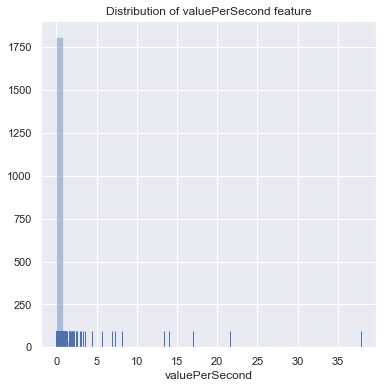

In [14]:
plt.figure(figsize=(6,6))
plt.title("Distribution of valuePerSecond feature")
sns.distplot(df.valuePerSecond, kde=False, rug=True)

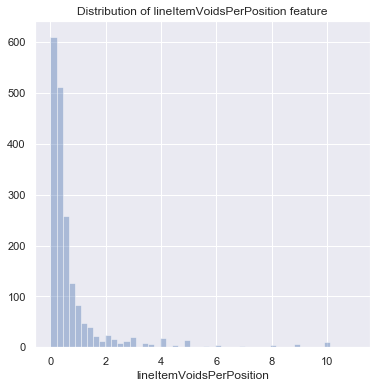

In [15]:
plt.figure(figsize=(6,6))
plt.title("Distribution of lineItemVoidsPerPosition feature")
sns.distplot(df.lineItemVoidsPerPosition, kde=False, rug=False)

Distribution of some of the features is rather regular and flat across the values spectrum while for others is highly skewed to the left side. Let's check the correlations between features.

### Correlations

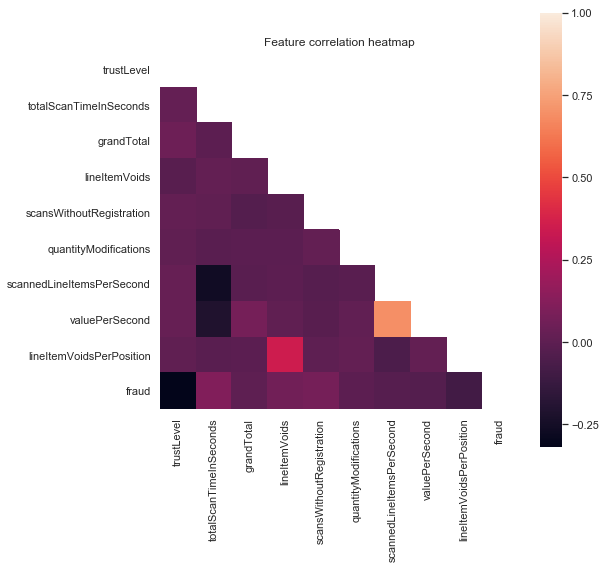

In [16]:
cmatrix = df.corr()
mask = np.zeros_like(cmatrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(8,8))
    plt.title("Feature correlation heatmap")
    sns.heatmap(cmatrix, mask=mask, square=True)

There is not much happening in the correlation heatmap. Other than features that are obviously correlated (like valuePerSecond and scannedLineItemsPerSecond) we do not observe any significant values. The time of scanning is negatively correlated with the speed of scanning and a slight negative correlation can be observed between the trustLevel and assigned class. Lets take a closer look at the trustLevel feature.

### Trust level - closer look

It seems that the trust level does not correlate significantly with the class value but it may be caused by the very uneven dristribution between classes. It may be profitable to check how this feature is ditributed among fraudulent and non-fraudulent transactions separately.

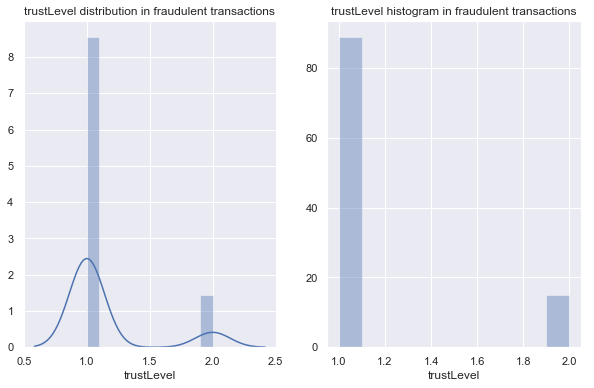

In [17]:
figure = plt.figure(figsize=(10,6))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)
ax1.set_title("trustLevel distribution in fraudulent transactions")
ax2.set_title("trustLevel histogram in fraudulent transactions")
sns.distplot(df[df['fraud']==1].trustLevel, kde=True, ax=ax1)
sns.distplot(df[df['fraud']==1].trustLevel, kde=False, ax=ax2)

Unique trustLevel feature values among fraud-postive transactions.

In [18]:
df[df['fraud']==1].trustLevel.unique()

array([1, 2])

It seems that the correlation indeed may has been lost in the noise caused by the data distribution. In the subgroup of fraudulent transactions only trust levels 1 and 2 show up. 

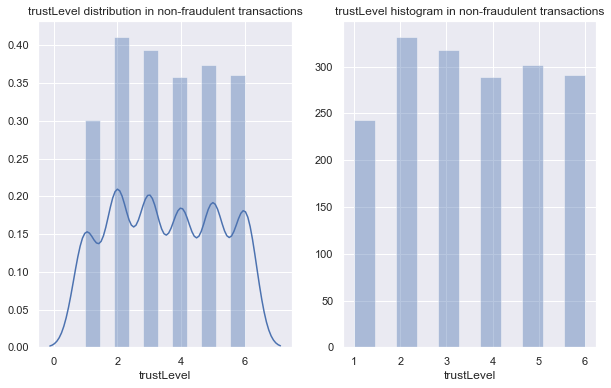

In [19]:
figure = plt.figure(figsize=(10,6))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)
ax1.set_title("trustLevel distribution in non-fraudulent transactions")
ax2.set_title("trustLevel histogram in non-fraudulent transactions")
sns.distplot(df[df['fraud']==0].trustLevel, kde=True, ax=ax1)
sns.distplot(df[df['fraud']==0].trustLevel, kde=False, ax=ax2)

Unique trustLevel feature values among fraud-negative transactions.

In [20]:
df[df['fraud']==0].trustLevel.unique()

array([5, 3, 6, 2, 4, 1])

In case of non-fraudulent transactions the distibution is more even. Although there is a significant decrease of transactions with trust level equal to 1. trustLevel may be a good indicator of whether the client clissifies for a follow-up check but it does not ultimately differentiate fraudlent and non-fraudlent transactions.

### Data subset creation

In [21]:
fraudulent = df[df['fraud']==1]
non_fraudulent = df[df['fraud']==0]
n = fraudulent.count()[0]
non_fraudulent_subset = non_fraudulent.sample(n)

In [22]:
n_fraudulent = fraudulent.count()[0]
n_non_fraudulent = non_fraudulent.count()[0]
print("Fraudulent transactions: {}, non-fraudulent transactions: {}".format(n_fraudulent, n_non_fraudulent))

Fraudulent transactions: 104, non-fraudulent transactions: 1775


In [23]:
fraudulent.reset_index(drop=True, inplace=True)
non_fraudulent_subset.reset_index(drop=True, inplace=True)
dfs = pd.concat([fraudulent, non_fraudulent_subset])

In [24]:
dfs.count()[0]

208

In [25]:
dfs.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
1,2,1397,62.59,7,9,4,0.017895,0.044803,0.280000,1
2,1,1385,34.68,5,8,4,0.019495,0.025040,0.185185,1
3,1,996,71.94,7,0,1,0.027108,0.072229,0.259259,1
4,2,1305,87.65,7,8,4,0.021456,0.067165,0.250000,1


In [26]:
dfs = dfs.sample(208).reset_index(drop=True)

In [27]:
dfs.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,1,1540,97.98,4,5,4,0.015584,0.063623,0.166667,1
1,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
2,1,1538,60.68,8,6,5,0.012354,0.039454,0.421053,1
3,4,1238,17.79,8,0,0,0.015347,0.014370,0.421053,0
4,2,295,92.67,7,1,2,0.074576,0.314136,0.318182,0


### Feature normalisation

In [28]:
x = dfs.drop('fraud', axis=1)
y = dfs['fraud']

x = sklearn.preprocessing.scale(x)

/home/swizy/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


### t-SNE

In order to visualize the data it's dimensionality has to be reduced. We decided to utilise t-SNE algorithm to do so.

In [29]:
from sklearn.manifold import TSNE

In [30]:
x_embedded = TSNE(n_components=2, random_state=42).fit_transform(x)

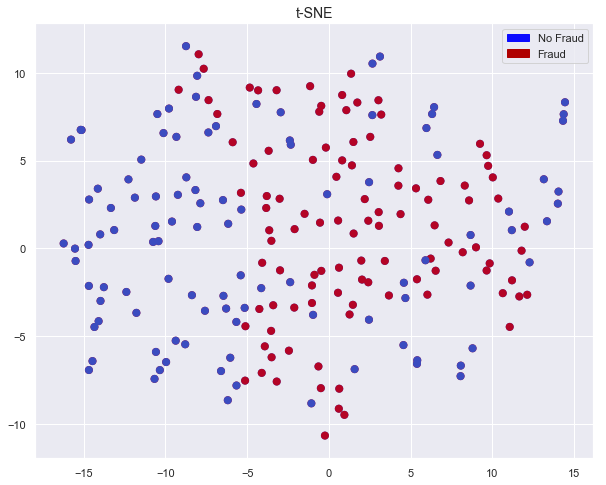

In [31]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(10,8))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(x_embedded[:,0], x_embedded[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(x_embedded[:,0], x_embedded[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

It looks like the fraudlent transactions are not much different from non-fraudlent ones although they do not spread across the entire space occupied by the non-fraudlent transactions.

The rest of this notebook consists of a simple check of a few classification models trained on the original data. More comprehensive tests were performed later and can be found in the notebook dedicated to over- and undersampling of data.

### Training/test sets

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [34]:
clf.feature_importances_

array([0.42460811, 0.03229965, 0.01937264, 0.03537906, 0.01714385,
       0.        , 0.31019425, 0.036398  , 0.12460444])

In [35]:
clf.score(X_test, y_test)

0.9047619047619048

### KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [37]:
neigh.score(X_test, y_test)

0.8095238095238095

### DecisionTree

In [38]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [39]:
tree.score(X_test, y_test)

0.8809523809523809

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(random_state=0, solver='liblinear', multi_class="ovr")
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
reg.score(X_test, y_test)

0.8571428571428571